# Standardization method
Haoyang Han

For every single time point and every single parameter, do standardization.

#### 1. Import dataset

In [2]:
# 1. Import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time
import os


# Define Hyperparameters
T = 30

Multi-variable analysis：

In [3]:
def import_dataset():
    '''
    read all 2-byte files and then concentrating them together. Follow this link:
    https://blog.csdn.net/brucewong0516/article/details/79062340
    '''
    x = []
    y = []
    # import x
    address = os.listdir(r'/opt/hhyang/Data/factors')
    for path in address:
        parent = r'/opt/hhyang/Data/factors'
        abs_path = os.path.join(parent, path)
        x_i = np.memmap(abs_path,dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
        x_i = np.asarray(x_i)
        x_i = x_i[:,0:1082]
        x_ = x_i.reshape(-1,1)
        x.append(x_)
        # print(abs_path)
    # import y
    price = np.memmap('/opt/hhyang/Data/quotes/stk_clsadj',dtype = np.float32, shape = (40000,1829))# ,shape = (204800, 1749))
    
    y = np.zeros((price.shape[0]-T,price.shape[1]))
    '''
    This is an iteration to create target y function;
    Here we use Return rate minus Average Return Rate.

    First we calculate the mean return rate for every single timeslot;
    Then we calculate the return rate of each stock and return them back to y.

    Here we used np.nanmean() function, in case some values would be nan.
    '''
    t0 = time.time()
    for i in range(40000-T): 
        avg = []
        for j in range(1082):
            avg.append(np.log(price[i+T,j-1]/price[i,j-1]))
        average = np.nanmean(avg)
        if i == 0:
            print("printing sample return rate:\n")
        if i <= 10:
            print(average)
        for j in range(1082):
            y[i,j-1] = np.log(price[i+T,j-1]/price[i,j-1])-average
    t1 = time.time()
    y = y[:,0:1082]
    y_ = y.reshape(-1,1)
    

    print("y function running time should be, ", t1-t0)
    print("the shape of x is:", np.shape(x))
    print("the shape of y is:", y_.shape)
    return x, y

In [4]:
x_, y_ = import_dataset()


printing sample return rate:

0.0013800772
0.0016703203
0.0011641694
0.00053213275
2.9085128e-05
0.00012998495
0.00043640524
0.0013618168
0.0022976901
0.0023563607
0.0025168792
y function running time should be,  553.167578458786
the shape of x is: (21, 43280000, 1)
the shape of y is: (43247540, 1)


#### 2. Feature Engineering

Outline for possible solution:
1. Standardization
2. Develop Sharpe Ratio Criteria
3. Select best Ratios

##### 1. Standardization

In [5]:
def standardization(x):
    # x = np.asarray(x)
    x = np.squeeze(x).T
    print('the shape of input matrix is %d, %d' %(x.shape[0],x.shape[1]))
    
    t0 = time.time()
    x_bar = np.zeros(x.shape)
    for i in range(int(x.shape[0] / 1082)):
        for j in range(21):
            x_ = x[i * 1082: i* 1082 + 1082, j]
            max_x = np.nanmax(x_) #there exist nan value in this np array
            min_x = np.nanmin(x_)
            if max_x - min_x != 0:
                x_hat = (x_ - min_x)/(max_x - min_x) # this should be a range(0,1) standardization
                x_hat = 2 * x_hat - 1
                x_bar[i * 1082: i* 1082 + 1082, j] = x_hat
            else:
                x_hat = np.zeros(1082)
                x_bar[i * 1082: i* 1082 + 1082, j] = x_hat
    t1 = time.time()
    print('Total transfer time is %d' %(t1-t0))
    x_bar = np.asarray(x_bar)
    return x_bar

def nan_transfer(x):
    where_are_nan = np.isnan(x)
    where_are_inf = np.isinf(x)
    x[where_are_nan] = 0
    x[where_are_nan] = 0
    return x

In [6]:
x__ = standardization(x_)
x__ = nan_transfer(x__)

the shape of input matrix is 43280000, 21
Total transfer time is 53


In [7]:
x__.shape

(43280000, 21)

Deciding which parameter to delete. 

In [8]:
# deleted 
'''
We should run this step for every single program run.
'''

'\nWe should run this step for every single program run.\n'

In [9]:
x_del = np.delete(x__, [3, 8, 17], axis = 1)


In [10]:
x_del.shape

(43280000, 18)

In [11]:
x_hat = x_del[:20000000,].T
np.isnan(x_hat).sum()

0

In [12]:
x_hat.shape

(18, 20000000)

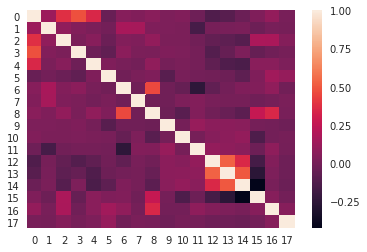

In [13]:
pearson_ = np.corrcoef(x_hat)

for i in range(len(pearson_)):
    for j in range(len(pearson_)):
        if i != j:
            if abs(pearson_[i,j]) > 0.6:
                print("the %d, %d parameters are correlated, it's value should be: %f" % (i, j, pearson_[i, j]))
                
sns.heatmap(pearson_)

#### 3. Splitting Data

In [16]:
def train_test_split(x, y):
    '''
    此时的情况是：T = 30，
                  40000 * 1082（21个features）的input x，被拉长为4.328e7 * 21 的数列。
                  39970 * 1082（1个output return）的output，被拉长为4.3248e7 * 21的数列。
    举简单的例子：用T = 3的情况，此时前面三个没有数字
 X：| | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
    | | | | | | | |
 P：| | | | | | | |
 Y:       | | | | | | | |
    但是后面三个predicted y其实也没有（因为没有相对应的price做预测）
    既然是相对收益率，那我认为应当截去X的头部30（行）（因其无法产生任何有效的收益率数值）
    train_test分裂暂时使用35000-30:5000
        x_numpy = x_numpy[,:0:1:,]
    '''
    # define hyper-parameter:
    
    
    x = np.asarray(x)
    # x = np.delete(x, [3, 8, 16], axis = 0)
    y = np.asarray(y)
    y = y.reshape(-1,1)
    '''  
    # Cut first 30 rows of x
    # 30 * 1082 = 32460
    x = x[32460:,:]


    # transfer nan to 0
    x = np.nan_to_num(x)
    y = np.nan_to_num(y)
    '''
    print(np.shape(x))
    print(y.shape)
    
    # cutting first 
    train_X = x[:37837540,:]    # 3-D to 2-D
    train_y = y[:37837540,:]
    test_X = x[37837540:43247540,:]
    test_y = y[37837540:,:]
    '''
    train_X= np.nan_to_num(train_X)
    train_y= np.nan_to_num(train_y)
    test_X= np.nan_to_num(test_X)
    test_y= np.nan_to_num(test_y)
    '''
    print("The shape of training set's X is,",train_X.shape)
    print("The shape of training set's y is,",train_y.shape)
    print("The shape of testing set's X is,",test_X.shape)
    print("The shape of testing set's y is,",test_y.shape)

    
    return train_X, train_y, test_X, test_y

In [15]:
train_X, train_y, test_X, test_y = train_test_split(x_del, y_)

(43280000, 18)
(43247540, 1)
The shape of training set's X is, (37837540, 18)
The shape of training set's y is, (37837540, 1)
The shape of testing set's X is, (5410000, 18)
The shape of testing set's y is, (5410000, 1)


In [ ]:
'''
Save training and testing dataset seperately to reduce model_fitting time.
'''
np.savetxt('/opt/hhyang/train_X',train_X, delimiter=",")
np.savetxt('/opt/hhyang/train_y',train_y, delimiter=",")
np.savetxt('/opt/hhyang/test_X',test_X, delimiter=",")
np.savetxt('/opt/hhyang/test_y',test_y, delimiter=",")


#### 4. Model_fittig


这里我们首先先用sklearn进行一系列的最简单的模型判断，以确保我们的数据和模型是可以使用的。在这个条件下，我们暂时用RMSE作为评判标准，因为数据大小变化不明显，用MSE作为评判标准会出现数值过小而无法评价的问题。

使用的模型为：
1. Linear
2. Ridge
3. <font color = #ff0000> KNN </font>
4. Lasso
5. Bayesian
6. <font color = #ff0000> MLP </font>
7. Decision Tree
8. Random Forest
9. <font color = #ff0000> SGD </font>
10. Gradient Boosting Decision Tree
11. AdaBoost
12. SVM regression

In [15]:
# Preparing for several judgement parameter



# Accuracy
from sklearn.metrics import accuracy_score as acc_s
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr

'''
Since this is a regression problem instead of classification, 
we shouldn't use accuracy_score(compared one element from each other in this case .)
Use MSE and RMSE criteria instead.

'''

def rmse(y_test, y_pred):
    return np.sqrt(mse(y_test, y_pred))

def IC(x1, x2):
    pearson = []
    x1 = np.squeeze(x1)
    x2 = np.squeeze(x2)
    for i in range(int(np.shape(x1)[0]/1082)):
        x1_ = x1[i*1082:i*1082+1082,]
        x2_ = x2[i*1082:i*1082+1082,]
        pearson_ = pearsonr(x1_, x2_)[0]
        pearson.append(pearson_)
    pearson = np.asarray(pearson)
    pearson = np.squeeze(pearson)
    '''
    print(np.isnan(pearson).sum())
    print(pearson.shape)
    print(pearson.mean())
    print(pearson.std())
    '''
    temp = pearson.mean()/pearson.std()
    return temp

def nan_transfor(x):
    where_are_nan = np.isnan(x)
    where_are_inf = np.isinf(x)
    x[where_are_nan] = 0
    x[where_are_nan] = 0
    return x

def predictor(func):
    y_hat = func.predict(pred_x)
    y_hat = y_hat.reshape(40000,-1)
    return y_hat

In [16]:
'''
Clear content of all memories
'''
Method = []
MSE = []
RMSE = []
Time = []
y_hat = []
ic = []

##### a. Linear

In [17]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
t0 = time.time()
linear.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = linear.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
accuracy3 = IC(pred_y, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)
print("The IC criteria is:", accuracy3)

Method.append('Linear')
MSE.append(accuracy1)
RMSE.append(accuracy2)
ic.append(accuracy3)
Time.append(t1-t0)
y_hat.append(pred_y)


total time used for model fitting is: 487.62732434272766
The mse of linear regression is: 2.6396798090616922e-05
The rmse of linear regression is: 0.0051377814366336105
The IC criteria is: 22.095781132949966


##### b. Ridge

In [18]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 0.5)
t0 = time.time()
ridge.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = ridge.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
accuracy3 = IC(pred_y, test_y)

print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)
print("The IC criteria is:", accuracy3)

Method.append('Ridge')
MSE.append(accuracy1)
RMSE.append(accuracy2)
ic.append(accuracy3)
Time.append(t1-t0)
y_hat.append(pred_y)

total time used for model fitting is: 8.61470651626587
The mse of linear regression is: 2.6396798079787724e-05
The rmse of linear regression is: 0.005137781435579731
The IC criteria is: 22.09578022453156


##### c. K-Nearest Neighbor

In [19]:
train_y_ =  np.squeeze(train_y)
test_y_ =  np.squeeze(test_y)
train_y_.shape

(37837540,)

In [ ]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor(n_neighbors = 5,
                          leaf_size = 50, 
                          # p = 2 for euclidean distance,
                         n_jobs = 10)
t0 = time.time()
KNN.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
'''
KNN prediction time is extremely slow!
'''
pred_y = KNN.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('K Nearest Neighbor')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 1624.9246447086334


##### d. Lasso

In [20]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.1)
t0 = time.time()
lasso.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y_ = lasso.predict(test_X)
accuracy1 = mse(pred_y_, test_y)
accuracy2 = rmse(pred_y_, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Lasso')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y_)

accuracy3 = IC(pred_y_, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 15.690503358840942
The mse of linear regression is: 4.475829667531558e-05
The rmse of linear regression is: 0.006690164174018122
The IC criteria is: 0.02075470667530946


##### e. Bayesian

In [21]:
# Here we will import several functions in sklearn for model simulation.
from sklearn.linear_model import BayesianRidge
bridge = BayesianRidge()
t0 = time.time()
bridge.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = bridge.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Bayesian')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 155.34583854675293
The mse of linear regression is: 2.6396797936657645e-05
The rmse of linear regression is: 0.005137781421650559
The IC criteria is: 22.095768216679982


##### f. Multilayer Perceptron 

In [ ]:
from sklearn.neural_network import MLPregressor
MLP = MLPregressor(activation  = 'relu',
                   solver = 'adam',
                   alpha = 1e-5,
                   batch_size = 'auto', # = min(200, n_samples)
                   learning_rate = 'adaptive'
                   )

t0 = time.time()
MLP.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = MLP.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of SVM regression is:", accuracy1)
print("The rmse of SVM regression is:", accuracy2)



Method.append('Multilayer Perceptron')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

##### g. Decision Tree

调参方法主要看官方文档

In [22]:
from sklearn.tree import DecisionTreeRegressor
DTregression = DecisionTreeRegressor(splitter = 'random',
                                    max_features = 'log2',
                                    max_depth = 10,
                                    min_samples_split = 10,
                                    min_samples_leaf = 10,
                                    )

t0 = time.time()
DTregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = DTregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Decision Tree regression is:", accuracy1)
print("The rmse of Decision Tree regression is:", accuracy2)

Method.append('Decision Tree')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 66.44618821144104
The mse of Decision Tree regression is: 2.6484420593736758e-05
The rmse of Decision Tree regression is: 0.005146301642319148
The IC criteria is: 12.387085947544675


##### h. RF

In [23]:
from sklearn.ensemble import RandomForestRegressor
RFregression = RandomForestRegressor(max_features = 'log2',
                                     max_depth = 10,
                                     min_samples_split = 10,
                                     min_samples_leaf = 10,
                                     n_jobs = 10
                                    )

t0 = time.time()
RFregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = RFregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('Random Forest')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 296.42095255851746
The mse of Random Forest regression is: 1.5027250437559773e-05
The rmse of Random Forest regression is: 0.0038764997662272304
The IC criteria is: 25.97925870241772


##### i.SGD

In [ ]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDRegressor
SGD = SGDRegressor(# loss = 'squared_loss'
                    penalty = 'l2',
                    alpha = 1e-5,
                    learing_rage = 'optimal'
                   )

t0 = time.time()
SGD.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = SGD.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('Stochastic Gradient Descent')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

##### j.GBDT

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
GBDT = GradientBoostingRegressor(n_estimators = 10,
                                subsample = 0.5,
                                min_samples_split = 10,
                                min_samples_leaf = 10,
                                max_features = 'log2',
                                alpha = 0.9)

t0 = time.time()
GBDT.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = GBDT.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('GBDT')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 441.98339080810547
The mse of Random Forest regression is: 2.912803777722995e-05
The rmse of Random Forest regression is: 0.0053970397235178795
The IC criteria is: 15.576745833586426


##### k.AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators = 10)

t0 = time.time()
ada.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = ada.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of Random Forest regression is:", accuracy1)
print("The rmse of Random Forest regression is:", accuracy2)

Method.append('AdaBoost')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

total time used for model fitting is: 3361.827823638916
The mse of Random Forest regression is: 3.3286529551392556e-05
The rmse of Random Forest regression is: 0.005769447941648538
The IC criteria is: 8.590558497420094


##### i.Support Vector Machine

In [27]:
train_y_ =  np.squeeze(train_y)
test_y_ =  np.squeeze(test_y)
train_y_.shape

(37837540,)

In [ ]:
from sklearn.svm import SVR
svmregression = SVR(C=1.0, epsilon=0.2)

t0 = time.time()
svmregression.fit(train_X, train_y_)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = svmregression.predict(test_X)
accuracy1 = mse(pred_y, test_y_)
accuracy2 = rmse(pred_y, test_y_)
print("The mse of SVM regression is:", accuracy1)
print("The rmse of SVM regression is:", accuracy2)



Method.append('SVM')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

accuracy3 = IC(pred_y, test_y)
print("The IC criteria is:", accuracy3)
ic.append(accuracy3)

##### j. Polynominal

In [ ]:
'''
Polynominal 是一种延伸变量的预处理手段，不是回归时的模型。

# Here we will import several functions in sklearn for model simulation.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
t0 = time.time()
poly.fit(train_X, train_y)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = poly.predict(test_X)
accuracy1 = mse(pred_y, test_y)
accuracy2 = rmse(pred_y, test_y)
print("The mse of linear regression is:", accuracy1)
print("The rmse of linear regression is:", accuracy2)

Method.append('Polynomial')
MSE.append(accuracy1)
RMSE.append(accuracy2)
Time.append(t1-t0)
y_hat.append(pred_y)

'''


##### 6. 导出数据, 数据分析

In [133]:
Dict = {
    'mse':np.asarray(MSE),
    'rmse':np.asarray(RMSE),
    'time':np.asarray(Time),
    'IC':np.asarray(ic),
    # 'y_hat':y_hat
    # dataframe
}
result = pd.DataFrame(Dict, index = Method)


In [134]:
result

,mse,rmse,time,IC
Linear,0.000044,0.006663,13.771729,1.653329
Ridge,0.000011,0.003363,5.480013,24.518930
Bayesian,0.000011,0.003363,67.393884,24.520110
Decision Tree,0.000024,0.004911,57.129780,16.379122
Random Forest,0.000011,0.003292,295.299065,42.480742
GBDT,0.000024,0.004860,735.942172,28.636867
Lasso,0.000044,0.006637,1234.765212,1.248026
AdaBoost,0.000043,0.006525,5100.945332,5.721919
SVM,0.000731,0.027031,2033.369296,0.150877


In [72]:
result.to_csv('/opt/hhyang/result.csv')

<Figure size 432x288 with 0 Axes>

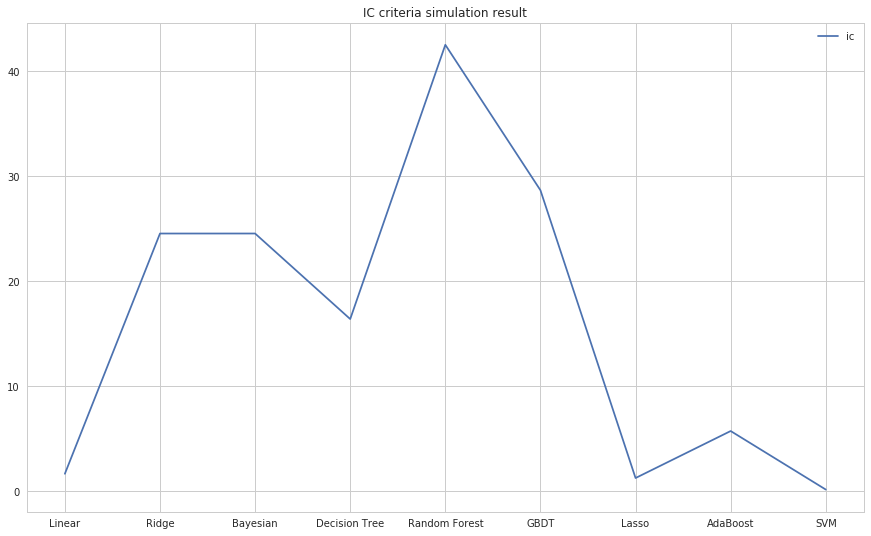

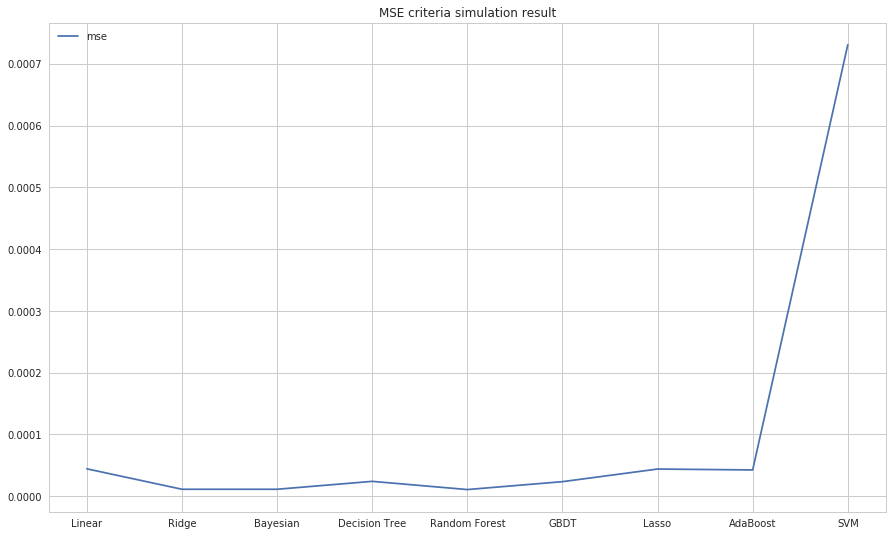

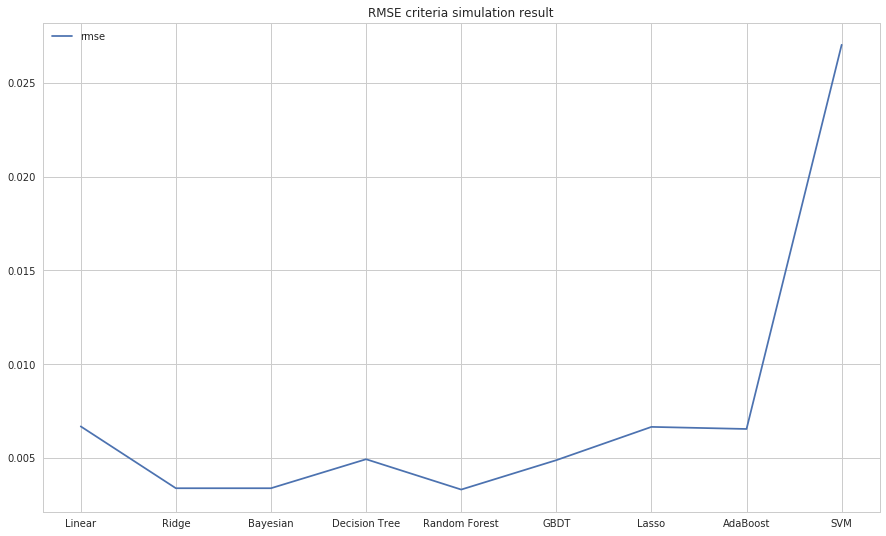

In [137]:

sns.despine()  
sns.set_style("whitegrid")  
plt.figure(figsize=(15,9))
plt.plot(result['IC'], label = 'ic')
plt.title("IC criteria simulation result")
plt.legend()
plt.show()

plt.figure(figsize=(15,9))
plt.plot(result['mse'], label = 'mse')
plt.title("MSE criteria simulation result")
plt.legend()
plt.show()

plt.figure(figsize=(15,9))
plt.plot(result['rmse'], label = 'rmse')
plt.title("RMSE criteria simulation result")
plt.legend()
plt.show()

In [59]:
# reshaping input x
pred_x = np.squeeze(x_).T
pred_x = nan_transfer(pred_x)
pred_x.shape

# outputs
y_hat_linear = predictor(linear)
y_hat_ridge = predictor(ridge)
y_hat_bridge = predictor(bridge)
y_hat_DTregression = predictor(DTregression)
y_hat_RFregression = predictor(RFregression)
y_hat_GBDT = predictor(GBDT)
y_hat_lasso = predictor(lasso)
y_hat_ada = predictor(ada)

In [65]:
np.savetxt('/opt/hhyang/linear.txt',y_hat_linear)
np.savetxt('/opt/hhyang/ridge.txt',y_hat_ridge)
np.savetxt('/opt/hhyang/bridge.txt',y_hat_bridge)
np.savetxt('/opt/hhyang/DecisionTree.txt',y_hat_DTregression)
np.savetxt('/opt/hhyang/RandomForest.txt',y_hat_RFregression)
np.savetxt('/opt/hhyang/GBDT.txt',y_hat_GBDT)
np.savetxt('/opt/hhyang/Lasso.txt',y_hat_lasso)
np.savetxt('/opt/hhyang/ada.txt',y_hat_ada)

In [103]:
# Stacking zeros for type
zeros = np.zeros((40000, 747))
y_hat_linear = np.c_[y_hat_linear, zeros]
y_hat_ridge = np.c_[y_hat_ridge, zeros]
y_hat_bridge = np.c_[y_hat_bridge, zeros]
y_hat_DTregression = np.c_[y_hat_DTregression, zeros]
y_hat_RFregression = np.c_[y_hat_RFregression, zeros]
y_hat_GBDT = np.c_[y_hat_GBDT, zeros]
y_hat_lasso = np.c_[y_hat_lasso, zeros]
y_hat_ada = np.c_[y_hat_ada, zeros]

In [114]:
# Stacking zeros for type
zero = np.zeros((320, 1829))
y_hat_linear = np.r_[y_hat_linear, zero]
y_hat_ridge = np.r_[y_hat_ridge, zero]
y_hat_bridge = np.r_[y_hat_bridge, zero]
y_hat_DTregression = np.r_[y_hat_DTregression, zero]
y_hat_RFregression = np.r_[y_hat_RFregression, zero]
y_hat_GBDT = np.r_[y_hat_GBDT, zero]
y_hat_lasso = np.r_[y_hat_lasso, zero]
y_hat_ada = np.r_[y_hat_ada, zero]

In [117]:
# Transfer float64 into float32
y_hat_linear = y_hat_linear.astype('float32')
y_hat_ridge = y_hat_ridge.astype('float32')
y_hat_bridge = y_hat_bridge.astype('float32')
y_hat_DTregression = y_hat_DTregression.astype('float32')
y_hat_RFregression = y_hat_RFregression.astype('float32')
y_hat_GBDT = y_hat_GBDT.astype('float32')
y_hat_lasso = y_hat_lasso.astype('float32')
y_hat_ada = y_hat_ada.astype('float32')

In [134]:
pred_x = np.squeeze(x_).T
pred_x = np.delete(pred_x, [3, 8, 16], axis = 1)
pred_x = nan_transfer(pred_x)
print(pred_x.shape)

y_hat_linear = predictor(linear)
y_hat_lasso = predictor(lasso)

zeros = np.zeros((40000, 747))
y_hat_linear = np.c_[y_hat_linear, zeros]
y_hat_lasso = np.c_[y_hat_lasso, zeros]

zero = np.zeros((320, 1829))
y_hat_linear = np.r_[y_hat_linear, zero]
y_hat_lasso = np.r_[y_hat_lasso, zero]

y_hat_linear = y_hat_linear.astype('float32')
y_hat_lasso = y_hat_lasso.astype('float32')

y_hat_linear.tofile('/opt/hhyang/linear.bin')
y_hat_lasso.tofile('/opt/hhyang/lasso.bin')


(43280000, 18)


In [120]:
y_hat_linear.dtype

dtype('float32')

In [118]:
# Output into requried type.
# 288 k kb
y_hat_linear.tofile('/opt/hhyang/linear.bin')
y_hat_ridge.tofile('/opt/hhyang/ridge.bin')
y_hat_bridge.tofile('/opt/hhyang/bridge.bin')
y_hat_DTregression.tofile('/opt/hhyang/DTregression.bin')
y_hat_RFregression.tofile('/opt/hhyang/RFregression.bin')
y_hat_GBDT.tofile('/opt/hhyang/GBDT.bin')
y_hat_lasso.tofile('/opt/hhyang/lasso.bin')
y_hat_ada.tofile('/opt/hhyang/ada.bin')

##### Logistics 不用了

这里要用标准化的方法。
x_bar = (x - MIN)/(MAX-MIN)

回归问题不要用分类模型（虽然可以做）

In [ ]:
'''
Standardization process.
'''
y_max = np.nanmax(y_)
y_min = np.nanmin(y_)
def standardization(x):
    return (x-y_min)/(y_max - y_min)
train_y_logistic = standardization(train_y)
test_y_logistic = standardization(test_y)

In [23]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
t0 = time.time()
logistic.fit(train_X, train_y_logistic)
t1 = time.time()
print("total time used for model fitting is:", t1-t0)
pred_y = logistic.predict(test_X)
accuracy1 = mse(pred_y, test_y_logistic)
accuracy2 = rmse(pred_y, test_y_logistic)
print("The mse of logistics regression is:", accuracy1)
print("The rmse of logistics regression is:", accuracy2)

/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: 'continuous'

## 6. 后续工作

后续工作会根据之前工作的进行，大致方向为：研究 in-sample/out of sample strategy 进行一些机器学习的研究：
    1. 训练出模型/accuracy/bais/variance 尝试各种各样的建模方式 最顺手而且性能更好；
    2. 做出模型后如何进行交易、什么条件下进行买卖、增强学习。


1. 因模型运作时间过长，我们需要继续探索Bagging/SVM/Kernal Ridge Regression的运作情况。

In [126]:
# Bagging Regression

In [127]:
# SVM Regression

In [128]:
# Kernal Ridge Regression

2. 使用如下优化方法对模型进行优化：

In [17]:
# Normalized Gradient Descent

In [18]:
# Stogastic Gradient Descent

In [19]:
# Batch Gradient Descent

In [20]:
# Monmentum Gradient Descent

3. 使用如下深度学习模型拟合数据：

In [121]:
# MLP

In [21]:
# Simple RNN

In [22]:
# GRU-RNN

In [129]:
# LSTM-RNN

In [130]:
# GAN-RNN

4. 使用如下降维方式增加效率

In [122]:
# PCA

In [123]:
# LDA

In [124]:
# LLE 

In [125]:
# Laplacian Eigenmaps